# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020-23 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

In [16]:
!pip uninstall numpy -y
!pip install numpy==1.22.0

  Using cached numpy-1.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [3]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from tqdm import tqdm

In [2]:
from sklearn.cluster import KMeans


### Input data
This opens input data files and assigns them to variables.

In [4]:
path = './data/' # set this to '' to run on the GitHub version
events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
events_down = uproot.open(path+'B2HHH_MagnetDown.root')
events_up = uproot.open(path+'B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [5]:
from src.invariant_mass import find_invariant_mass

In [4]:
# def find_invariant_mass_simulation(momentum_1=[0, 0, 0],
#                                    momentum_2=[0, 0, 0],
#                                    momentum_3=[0, 0, 0],
#                                    mass_array=[493.677, 493.677, 493.677]):
    
#         p1_x, p1_y, p1_z = momentum_1
#         p2_x, p2_y, p2_z = momentum_2
#         p3_x, p3_y, p3_z = momentum_3
    
#         E1 = np.sqrt(np.square(p1_x) + np.square(p1_y) + np.square(p1_z) + np.square(mass_array[0]))
#         E2 = np.sqrt(np.square(p2_x) + np.square(p2_y) + np.square(p2_z) + np.square(mass_array[1]))
#         E3 = np.sqrt(np.square(p3_x) + np.square(p3_y) + np.square(p3_z) + np.square(mass_array[2]))
        
#         energy_squared   = np.square(E1 + E2 + E3)
#         total_momentum_x = p1_x + p2_y + p3_z
#         total_momentum_y = p1_x + p2_y + p3_z
#         total_momenum_z  = p3_x + p3_y + p3_z
#         #total momentum
#         inv_mass_squared = energy_squared - np.square(
#             total_momentum_x) - np.square(total_momentum_y) - np.square(total_momenum_z)

#         return np.sqrt(inv_mass_squared)

In [6]:
list_of_interesting_keys = []
for i in range(1, 4):
    exec(f"list_of_interesting_keys.append('H{i}_PX')")
    exec(f"list_of_interesting_keys.append('H{i}_PY')  ")
    exec(f"list_of_interesting_keys.append('H{i}_PZ')  ")
    exec(f"list_of_interesting_keys.append('H{i}_Charge')  ")
    exec(f"list_of_interesting_keys.append('H{i}_ProbK')  ")
    exec(f"list_of_interesting_keys.append('H{i}_ProbPi')  ")
    exec(f"list_of_interesting_keys.append('H{i}_isMuon')  ")


def read_file(path_name="", MAX_EVENTS=1000, mode=1, keys = list_of_interesting_keys,
              selection=False):

    if not path_name:
        path = 'data/'  # set this to '' to run on the GitHub version
    else:
        path = path_name

    #temporarily 
    event_counter = 0

    pX = []
    pY = []
    pZ = []
    pT = []


    h1_probpi = []
    h1_probk = []

    h2_probpi = []
    h2_probk = []

    h3_probpi = []
    h3_probk = []

    master_probpi = []
    master_probk = []

    invariant_mass_array = []



    print("Input data varaiables: ")
    if mode == 0:
        events_test = uproot.open(path+'example_file.root')
        print("Test mode")
        trees = [events_test['PhaseSpaceTree;1']]  # Test mode
#        return [[0], [0], [0], [0]]
        print(events_test.keys())

    elif mode == 1:
        events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
        trees = [events_sim['PhaseSpaceTree']]                       # Simulation
        print("Phase space simulation")
        print(events_sim.keys())
    elif mode == 2:
        # Magnet down data
        events_down = uproot.open(path+'B2HHH_MagnetDown.root')
        trees = [events_down['DecayTree']]
        print("Magnet down data")
        print(events_down.keys())
    elif mode == 3:
        # Magnet up data
        events_up = uproot.open(path+'B2HHH_MagnetUp.root')
        trees = [events_up['DecayTree']]
        print("Magnet up data")
        print(events_up.keys())
    elif mode == 4:
        trees = [events_down['DecayTree'], events_up['DecayTree']]
        print("Magnet up and down data")
        print(events_down.keys())
    else:
        print("Mode not recognised")
        return [[0], [0], [0], [0]]
    print("Varialbes read")
    print()
    for tree in trees:
        # This outer loop is a technical loop of uproot over chunks of events
        for data in tree.iterate(keys):
            # As Python can handle calculations with arrays, we can calculate derived quantities here
            pT_H1 = np.sqrt(data['H1_PX']**2+data['H1_PY']**2)
            pT_H2 = np.sqrt(data['H2_PX']**2+data['H2_PY']**2)
            pT_H3 = np.sqrt(data['H3_PX']**2+data['H3_PY']**2)

            p1_array = [data['H1_PX'], data['H1_PY'], data['H1_PZ']]
            p2_array = [data['H2_PX'], data['H2_PY'], data['H2_PZ']]
            p3_array = [data['H3_PX'], data['H3_PY'], data['H3_PZ']]

            # Your invariant mass calculation should go here
            inv_mass = find_invariant_mass(p1_array, p2_array, p3_array)
            invariant_mass_array.append(inv_mass)
            #invariant_mass_array.append(0)





            # This loop will go over individual events
            for i in tqdm(range(0, len(data['H1_PZ']))):
                event_counter += 1
                if 0 < MAX_EVENTS and MAX_EVENTS < event_counter:
                    break
                if 0 == (event_counter % 100000):
                    print('Read', event_counter, 'events')
                # Decide here which events to analyse
                if (data['H1_PZ'][i] < 0) or (data['H2_PZ'][i] < 0) or (data['H3_PZ'][i] < 0):
                    continue


                if selection:
                    probabilities_itr = [[data['H1_ProbK'][i], data['H1_ProbPi'][i]],
                                        [data['H2_ProbK'][i], data['H2_ProbPi'][i]],
                                        [data['H3_ProbK'][i], data['H3_ProbPi'][i]]]
                    charges_itr = [data['H1_Charge'][i], data['H2_Charge'][i], data['H3_Charge'][i]]
                    muon_prob = [data['H1_isMuon'][i], data['H2_isMuon'][i], data['H3_isMuon'][i]]
                
                    #check if any of the muon_prob is 1
                    if any(muon_prob):
                        continue

                    if selection_rule_iterator(probabilities_itr, charges_itr) is False:
                        continue

                    if assign_kaon_iterator(probabilities_itr, charges_itr) is False:
                        continue

                
                # Fill arrays of events to be plotted and analysed further below
                # Adding values for all three hadrons to the same variable here
                pT.append(pT_H1[i])
                pT.append(pT_H2[i])
                pT.append(pT_H3[i])
                pX.append(data['H1_PX'][i])
                pX.append(data['H2_PX'][i])
                pX.append(data['H3_PX'][i])
                pY.append(data['H1_PY'][i])
                pY.append(data['H2_PY'][i])
                pY.append(data['H3_PY'][i])
                pZ.append(data['H1_PZ'][i])
                pZ.append(data['H2_PZ'][i])
                pZ.append(data['H3_PZ'][i])

                #
                h1_probpi.append(data['H1_ProbPi'][i])
                h1_probk.append(data['H1_ProbK'][i])
                h2_probpi.append(data['H2_ProbPi'][i])
                h2_probk.append(data['H2_ProbK'][i])
                h3_probpi.append(data['H3_ProbPi'][i])
                h3_probk.append(data['H3_ProbK'][i])
                
                ##
                master_probpi.append(data['H1_ProbPi'][i])
                master_probk.append(data['H1_ProbK'][i])
                master_probpi.append(data['H2_ProbPi'][i])
                master_probk.append(data['H2_ProbK'][i])
                master_probpi.append(data['H3_ProbPi'][i])
                master_probk.append(data['H3_ProbK'][i])

    print(f"Read {event_counter:d} events")

    return [pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (master_probpi, master_probk), invariant_mass_array]
pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (master_probpi, master_probk), invariant_mass_array = read_file(mode=1,
                                                                                                                                                     MAX_EVENTS=100)


Input data varaiables: 
Magnet down data
['DecayTree;1']
Varialbes read



  0%|          | 100/1085998 [00:00<24:49, 729.13it/s]


: 

: 

In [6]:
# # Check what's in the tree. 
# # Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
# print('Input data variables:')
# print(events_up['DecayTree'].keys())

# # These are the arrays to hold the data
# pT = []
# pX = []
# pY = []
# pZ = []


# h1_probpi = []
# h1_probk = []

# h2_probpi = []
# h2_probk = []

# h3_probpi = []
# h3_probk = []

# master_probpi = []
# master_probk = []

# invariant_mass_array = []
# # A counter for bookkeeping
# event_counter = 0

# # If set to a value greater than 0, limits the number of events analysed
# # Set to -1 to run over all events. 
# # It is recommended to keep the number of events limited while developing the analysis.
# MAX_EVENTS = 50000
# MAX_EVENTS = 1000
# # Select which set of input data is to be analysed. Uncomment exactly one line
# trees = [events_sim['PhaseSpaceTree']]                       # Simulation
# #trees = [events_down[b'DecayTree']]                          # Magnet down data
# #trees = [events_up['DecayTree']]                             # Magnet up data
# #trees = [events_down[b'DecayTree'],events_up['DecayTree']]   # Magnet down+up data

# # This loop goes over the trees to be analysed
# for tree in tqdm(trees):
#     # This outer loop is a technical loop of uproot over chunks of events
#     for data in tqdm(tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon'])):
#         # As Python can handle calculations with arrays, we can calculate derived quantities here
#         pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
#         pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
#         pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)
        
#         p1_array = [data[b'H1_PX'], data[b'H1_PY'], data[b'H1_PZ']]
#         p2_array = [data[b'H2_PX'], data[b'H2_PY'], data[b'H2_PZ']]
#         p3_array = [data[b'H3_PX'], data[b'H3_PY'], data[b'H3_PZ']]
        

#         # Your invariant mass calculation should go here
#         invariant_mass = find_invariant_mass_simulation(p1_array, p2_array, 
#                                                         p3_array)
#         invariant_mass_array.append(invariant_mass)
#         # This loop will go over individual events
#         for i in range(0,len(data[b'H1_PZ'])):
#             event_counter += 1
#             if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
#             if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
#             # Decide here which events to analyse
#             if (data[b'H1_PZ'][i] < 0) or (data[b'H2_PZ'][i] < 0) or (data[b'H3_PZ'][i] < 0): continue
#             # Fill arrays of events to be plotted and analysed further below
#             # Adding values for all three hadrons to the same variable here
#             pT.append(pT_H1[i])
#             pT.append(pT_H2[i])
#             pT.append(pT_H3[i])
#             pX.append(data[b'H1_PX'][i])
#             pX.append(data[b'H2_PX'][i])
#             pX.append(data[b'H3_PX'][i])
#             pY.append(data[b'H1_PY'][i])
#             pY.append(data[b'H2_PY'][i])
#             pY.append(data[b'H3_PY'][i])
#             pZ.append(data[b'H1_PZ'][i])
#             pZ.append(data[b'H2_PZ'][i])
#             pZ.append(data[b'H3_PZ'][i])
            
#             #
#             h1_probpi.append(data[b'H1_ProbPi'][i])
#             h1_probk.append(data[b'H1_ProbK'][i])
#             h2_probpi.append(data[b'H2_ProbPi'][i])
#             h2_probk.append(data[b'H2_ProbK'][i])
#             h3_probpi.append(data[b'H3_ProbPi'][i])
#             h3_probk.append(data[b'H3_ProbK'][i])
            
#             ##
#             master_probpi.append(data[b'H1_ProbPi'][i])
#             master_probk.append(data[b'H1_ProbK'][i])
#             master_probpi.append(data[b'H2_ProbPi'][i])
#             master_probk.append(data[b'H2_ProbK'][i])
#             master_probpi.append(data[b'H3_ProbPi'][i])
#             master_probk.append(data[b'H3_ProbK'][i])            
            
 
# print('Read {:d} events'.format(event_counter))

Input data variables:
['B_FlightDistance', 'B_VertexChi2', 'H1_PX', 'H1_PY', 'H1_PZ', 'H1_ProbK', 'H1_ProbPi', 'H1_Charge', 'H1_IPChi2', 'H1_isMuon', 'H2_PX', 'H2_PY', 'H2_PZ', 'H2_ProbK', 'H2_ProbPi', 'H2_Charge', 'H2_IPChi2', 'H2_isMuon', 'H3_PX', 'H3_PY', 'H3_PZ', 'H3_ProbK', 'H3_ProbPi', 'H3_Charge', 'H3_IPChi2', 'H3_isMuon']


0it [00:00, ?it/s]/1 [00:00<?, ?it/s]
  0%|          | 0/1 [00:00<?, ?it/s]


TypeError: iterable of expressions must be strings or name, Interpretation pairs (length-2 tuples), not b'H*_P[XYZ]'

In [13]:
from src.file_reading import read_file

pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (master_probpi, master_probk), invariant_mass_array = read_file(mode=2, 
                                                                                                                                                     MAX_EVENTS=10000)


Input data varaiables: 
Magnet down data
['DecayTree;1']
Varialbes read



  0%|          | 0/10000 [00:00<?, ?it/s]

Read 10004 events


### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 1D histogram
Plotting 2D histogram


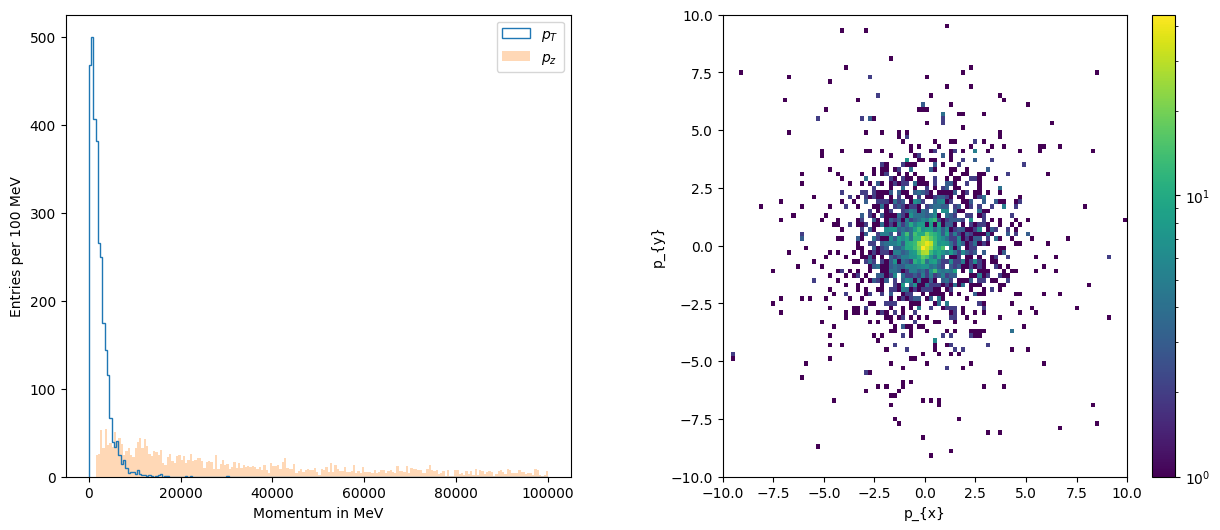

In [5]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(pT, bins = 200, range = [0, 100000],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel('p_{x}')
ax[1].set_ylabel('p_{y}')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('pXpY.pdf')

In [8]:
def plotting_histograms_probability(particle=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
    print('Plotting 1D histogram')
    if particle == 1:
        interest_pi = h1_probpi
        interest_k  = h1_probk
    if particle == 2:
        interest_pi = h2_probpi
        interest_k  = h2_probk
    if particle == 3:
        interest_pi = h3_probpi
        interest_k = h3_probk
        
    else:
        interest_pi = master_probpi
        interest_k = master_probk
    values_probpi, bins_probpi, patches_probpi = ax[0].hist(interest_pi, bins=100, range=[0,1], histtype='step', 
                                                             label='$Prob_{particle} Pion$')
    ax[0].hist(interest_k, bins = 100, range = [0, 1],histtype='stepfilled',alpha=0.3,label='$p_{particle} kaon$')
    ax[0].set_xlabel('Probability')
    ax[0].set_ylabel('Entries')
    ax[0].legend()
    #plt.savefig(f"Prob Pion vs Kaon Histogram particle{particle}")
    #plt.savefig(f"Prob_kaon_pion_{particle}.pdf")
    
    print('Plotting 2D histogram')
    h2d = ax[1].hist2d(interest_pi, interest_k,
                       bins = [100,100], range = [[0,1],[0,1]],norm=colors.LogNorm())
    ax[1].set_xlabel(f'Probability Pion ')
    ax[1].set_ylabel(f'Probability Kaon ')
    fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
    #plt.savefig(f"Prob_pi_prob_k_{particle}_2d.pdf")
    
    

In [ ]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_h1_probk, bins_h1_probk, patches_h1_probk = ax[0].hist(h1_probk, bins=100, range=[0,1], histtype='step', 
                                                             label='prob_h1k')
ax[0].hist(h1_probpi, bins = 100, range = [0, 1],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Probability vs ')
ax[0].set_ylabel('Entries')
ax[0].legend()
plt.savefig('pTpZ.pdf')




In [9]:
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel('p_{x}')
ax[1].set_ylabel('p_{y}')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('pXpY.pdf')

Plotting 2D histogram


NameError: name 'ax' is not defined

Plotting 1D histogram
Plotting 2D histogram


ValueError: too many values to unpack (expected 2)

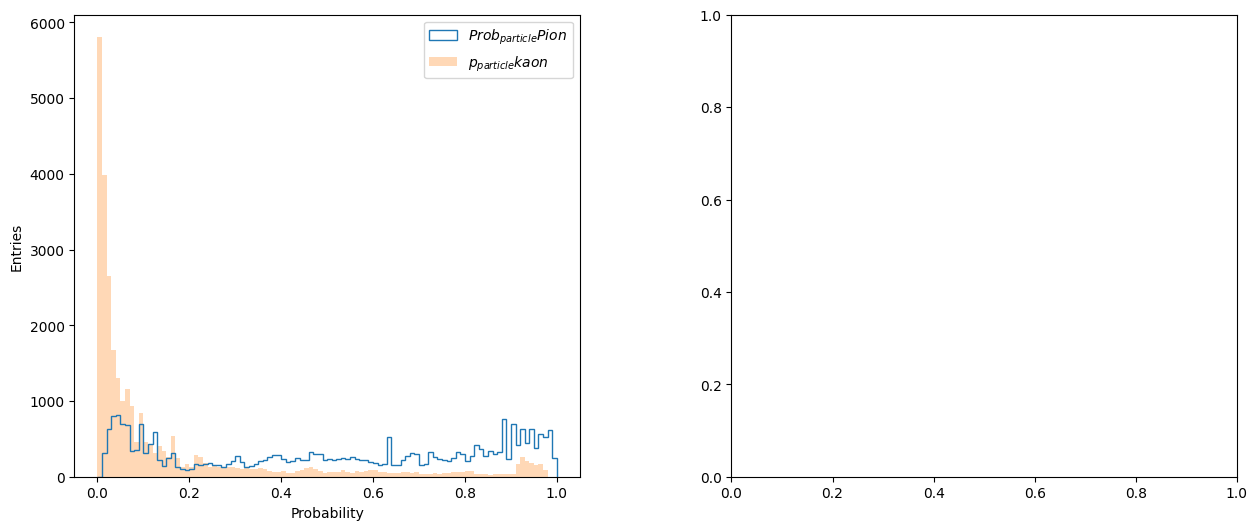

In [21]:
#for big boy 
plotting_histograms_probability(particle="all")

Plotting 1D histogram
Plotting 2D histogram


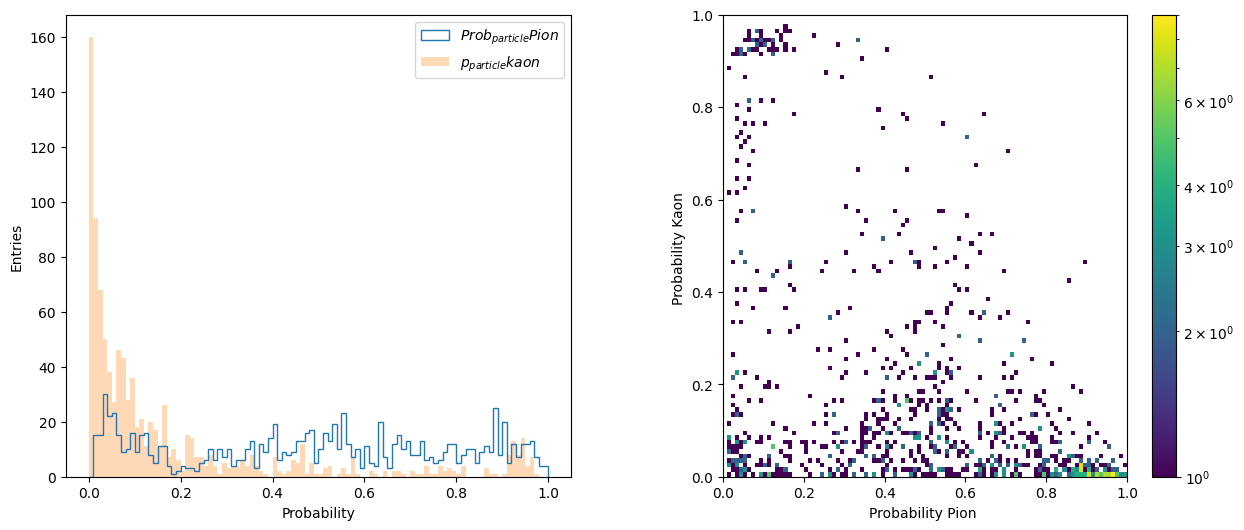

In [11]:
plotting_histograms_probability(3)

In [16]:
print(np.shape(pY))
print(np.shape(h1_probk))
print(np.shape(data[b'H1_ProbPi']))


(3000,)
(1000,)
(44583,)


## Clustering using SKLEARN

In [12]:
print(master_probpi[0:10])
print(master_probk[0:10])
print(np.shape(np.concatenate((master_probpi[0:10], master_probk[0:10]))))
print(np.concatenate((master_probpi[0:10], master_probk[0:10])))

[0.8887550830841064, 0.09576037526130676, 0.13884514570236206, 0.039063990116119385, 0.13743671774864197, 0.7586034536361694, 0.6366928219795227, 0.9861906170845032, 0.39960163831710815, 0.3509688079357147]
[0.038615524768829346, 0.3075411021709442, 0.19300395250320435, 0.07355624437332153, 0.04840672016143799, 0.08039650321006775, 0.030094534158706665, 0.0007981359958648682, 0.7507508993148804, 0.2114136815071106]
(20,)
[8.88755083e-01 9.57603753e-02 1.38845146e-01 3.90639901e-02
 1.37436718e-01 7.58603454e-01 6.36692822e-01 9.86190617e-01
 3.99601638e-01 3.50968808e-01 3.86155248e-02 3.07541102e-01
 1.93003953e-01 7.35562444e-02 4.84067202e-02 8.03965032e-02
 3.00945342e-02 7.98135996e-04 7.50750899e-01 2.11413682e-01]


In [15]:
print(np.shape(master_probpi))
print(np.shape(master_probk))

master_probpi = np.array(master_probpi).flatten()
master_probk  = np.array(master_probk).flatten()
master_probpi = np.expand_dims(master_probpi, axis=1)
master_probk  = np.expand_dims(master_probk, axis=1)

master_probability = np.concatenate((master_probpi, master_probk), axis=1)
print(np.shape(master_probability))
print(master_probability[0:10])

(30000, 1)
(30000, 1)
(30000, 2)
[[8.88755083e-01 3.86155248e-02]
 [9.57603753e-02 3.07541102e-01]
 [1.38845146e-01 1.93003953e-01]
 [3.90639901e-02 7.35562444e-02]
 [1.37436718e-01 4.84067202e-02]
 [7.58603454e-01 8.03965032e-02]
 [6.36692822e-01 3.00945342e-02]
 [9.86190617e-01 7.98135996e-04]
 [3.99601638e-01 7.50750899e-01]
 [3.50968808e-01 2.11413682e-01]]


In [18]:
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": [1,2,3,4,5,6],
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(master_probability)

KeyboardInterrupt: 

In [28]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
23,6,full,-1325.787143
17,6,diag,-1301.722993
16,5,diag,-1288.613113
22,5,full,-1256.068693
21,4,full,-1142.027535


/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


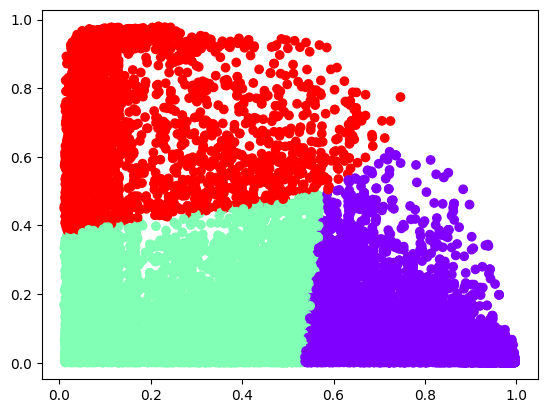

In [16]:
# fit a kmeans clustering model to the data
kmeans = KMeans(n_clusters=3, random_state=0).fit(master_probability)
#plot the clusters
plt.scatter(master_probability[:,0], master_probability[:,1], c=kmeans.labels_, cmap='rainbow')

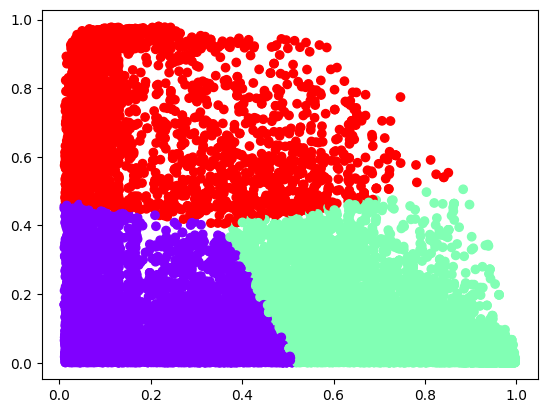

In [19]:
#fit a GMM model to the data using EM algorithm#
gmm = GaussianMixture(n_components=3, covariance_type='tied').fit(master_probability)
#plot the clusters
plt.scatter(master_probability[:,0], master_probability[:,1], c=gmm.predict(master_probability), cmap='rainbow')

## Finding Invariant Mass


Invariant Mass for a simulated dataset

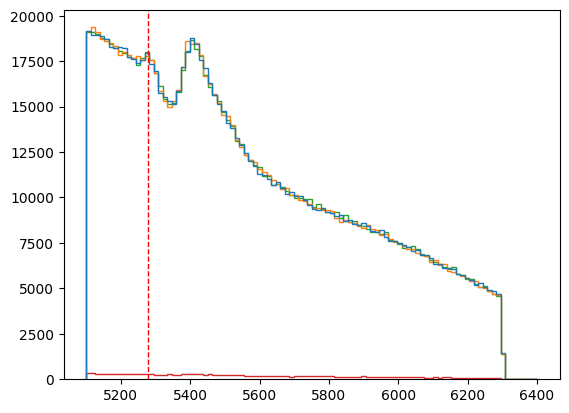

: 

In [6]:
plt.hist(invariant_mass_array, bins=100, range =[5100, 6400],  histtype='step', label='Invariant Mass');
plt.axvline(5279, color='r', linestyle='dashed', linewidth=1);

### Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

In [12]:
!pip install pymc3 --quiet

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
#use pymc3 to fit the data
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    # define priors
    mean = pm.Normal('mean', mu=5279, sd=100)
    sigma = pm.HalfNormal('sigma', sd=100)
    # define likelihood
    likelihood = pm.Normal('likelihood', mu=mean, sd=sigma, observed=invariant_mass_array)
    # inference!
    trace = pm.sample(1000, tune=1000, cores=1)

pm.traceplot(trace);


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



You can find the C code in this temporary file: /tmp/theano_compilation_error__w0k7t45


Exception: ("Compilation failed (return status=1): /usr/bin/ld: /usr/local/python/3.10.4/lib/libpython3.10.a(longobject.o): relocation R_X86_64_PC32 against symbol `PyExc_OverflowError' can not be used when making a shared object; recompile with -fPIC. /usr/bin/ld: final link failed: bad value. collect2: error: ld returned 1 exit status. ", 'FunctionGraph(Elemwise{true_div,no_inplace}(TensorConstant{1.0}, TensorConstant{0.0001}))')

Fit results with chi2/ndf 12.238053181579124 / 20
Par 1: 1021.864152 +/- 73.632609
Par 2: 5522.844963 +/- 267.679851
Par 3: 5465.510828 +/- 404.789910


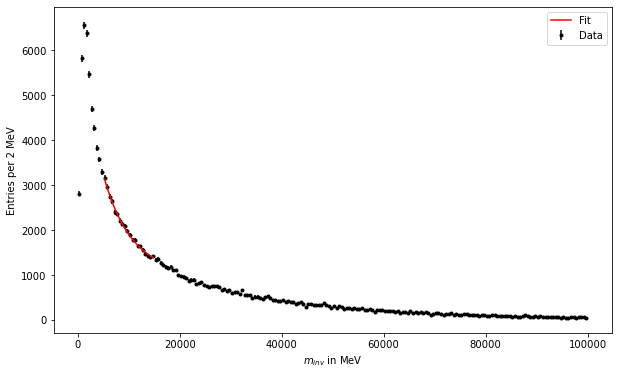

In [5]:
# decaying exponential function
def exponential(x, norm, decay):
    xoffset = 0 # this is a technical parameter, which can be used to move the position at which the function evaluates to "norm"
    return np.array( norm * np.exp(-(x-xoffset)/decay) )

# constant function
def constant(x, norm):
    return np.array( norm )

# fit function combining two individual functions
def fit_function(x, norm, normE, decay):
    return np.array( constant(x, norm) + exponential(x, normE, decay) )

def fit_data(bins, values, minX, maxX, p0):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays

    # reduce range to fit only part of curve
    bin_centres_red = [] 
    values_red = []
    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: continue
        bin_centres_red.append(c)
        values_red.append(v)

    # execute the fit with starting values as given in p0
    coeff_fit,cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0) # fit
    
    # evaluate chi2
    fit_vals = [fit_function(x,coeff_fit[0],coeff_fit[1],coeff_fit[2]) for x in bin_centres_red]
    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ), 
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    chi2 = np.sum( chi2parts )
    
    return coeff_fit,cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

def plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2])
    a.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

    # plot decoration
    a.legend()
    a.set_xlabel('$m_{inv}$ in MeV')
    a.set_ylabel('Entries per 2 MeV')
    plt.savefig(fname)

coeff_pT,cov_pT, bin_centres_pT, bin_centres_red_pT, chi2_pT, ndf_pT = fit_data( bins_pT, values_pT, 5000, 15000, [100,10000,10000] )

print_results(coeff_pT,cov_pT, chi2_pT, ndf_pT)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plot_results(ax,bin_centres_pT,bin_centres_red_pT,values_pT,coeff_pT,'fit_pT.pdf')

### Manipulation of 2D histograms

The following is an example code to demonstrate manipulation of the content of 2D histograms. It first produces two dummy histograms before working out the bin centres, subtracting the histogram contents, and finally plotting. The subtraction bit can of course be replaced by more complex operations as well.

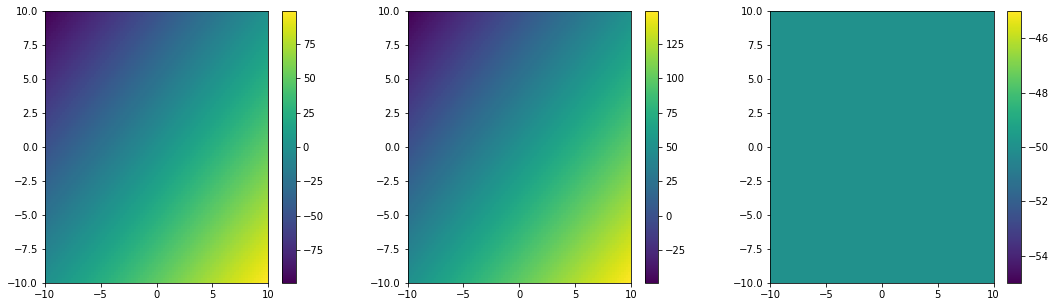

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

### ignore this bit and replace by however you produce your two 2D histograms to be subtracted ###
xvalues = []
yvalues = []
weights1 = []
weights2 = []
for x in range(100):
    for y in range(100):
        xvalues.append(-10+x/5.+0.1) # bin centre for x
        yvalues.append(-10+y/5.+0.1) # bin centre for y
        weights1.append((x-y))       # weights for histo1, this would be filled automatically
        weights2.append((x-y)+50)    # weights for histo2
h2d1 = ax[0].hist2d(xvalues,yvalues,weights=weights1,bins = [100,100], range = [[-10,10],[-10,10]])        
h2d2 = ax[1].hist2d(xvalues,yvalues,weights=weights2,bins = [100,100], range = [[-10,10],[-10,10]])
### end ignoring here :) ###

# first calculate the bin centres from the bin boundaries of the hist2d object
xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
wsub = np.subtract(w1,w2) # subtract bin content of two histograms

# produce the new histogram
h2d3 = ax[2].hist2d(xcentres,ycentres,weights=wsub, bins = [h2d1[1],h2d1[2]]) # recycle the binning from above

# plot the lot
fig.colorbar(h2d1[3],ax=ax[0]) # let's add the colour scale for histo 1
fig.colorbar(h2d2[3],ax=ax[1]) # let's add the colour scale for histo 2
fig.colorbar(h2d3[3],ax=ax[2]) # let's add the colour scale for histo 3